# SEP532 - 인공지능 이론과 실제 (2022 Spring)
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## 2 - Transfer learning with pre-trained CNNs


### 2-3. Feature extraction using pre-trained model

Constructing and training your own CNN models from scratch can be hard and a long task. A common trick used in deep learning is to use a **pre-trained** model and **fine-tune** it to the specific data it will be used for. 

The pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classificaton task. For the pre-trained model, we can either **use the pre-trained model as it is**, or **use transfer learning to customize this model** to a given task. 

The **intuition behind transfer learning** is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset.

In this practice, we will try two ways to customize a pre-trained model:
1. **Feature Extraction**: To extract meaningful features from new samples. We **simply add a new classifier**, which will be trained from scratch, **on top of the pretrained model** so that we can repurpose the feature maps learned previously for our dataset. To classify our task, we will **train the final parts of model**, classification part of the pre-trained model, thus, we do not need to (re)train the entire model.
1. **Fine-tuning**: Unfreezing a few of the top layers of a frozen model base and **jointly training both the newly-added classifier layers and the last layers of the base model**. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

#### Data preprocessing

We will first download and load the cats and dogs dataset using the [`Tensorflow Datasets`](https://www.tensorflow.org/datasets).
This [`tfds`](https://www.tensorflow.org/datasets/api_docs/python/tfds) package is the easiest way to load pre-defined data.

(If you want to use your own data and are interested in importing it, see the TensorFlow loading image data, [`tf.data`](https://www.tensorflow.org/beta/tutorials/load_data/images).

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The [`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method downloads and caches the data, and returns a [`tf.data.Dataset`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset) object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since "cats_vs_dog" doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

([`tfds.Split.TRAIN.subsplit`](https://www.tensorflow.org/datasets/api_docs/python/tfds/core/SplitBase?hl=en#subsplit): Divides this split into subsplits.)

In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Show the first two images and labels from the training set:
([`tfds.features.ClassLabel.int2str`](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/ClassLabel?hl=en#int2str): Conversion integer => class name string.)

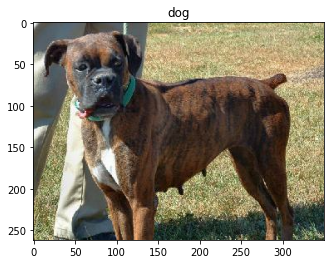

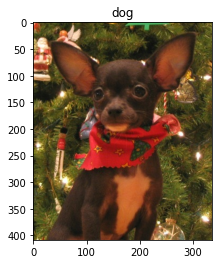

In [9]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

#### Format the data

Use the [`tf.image`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/image) module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels to a range of [-1,1]

In [12]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1  # -1~1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

[`tf.data.Dataset.map`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#map)(map_func, num_parallel_calls=None)

Maps `map_func` across the elements of this dataset.

This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements, in the same order as they appeared in the input.

Apply this function to each item in the dataset using the map method:

In [13]:
# There is map function in tf.
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

[`tf.data.Dataset.shuffle`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#shuffle)(buffer_size, seed=None, reshuffle_each_iteration=None)

Randomly shuffles the elements of this dataset.

[`tf.data.Dataset.batch`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#batch)(batch_size, drop_remainder=False)

Combines consecutive elements of this dataset into batches.

Now shuffle and batch the data.

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [15]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [16]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

#### Create the base model from the pre-trained convnets

We will create the base model from the **MobileNet V2 model** developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. 

First, we need to **pick which layer of MobileNet V2 we will use for feature extraction**. Obviously, the very last classification layer is not very useful. Instead, we will follow the common practice to instead depend on the **very last layer before the flatten operation**. This layer is called the "_bottleneck layer_". The **bottleneck features retain much generality** as compared to the final/top layer.

To do this, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the _include_top=False_ argument, we can **load a network that doesn't include the classification layers** at the top, which is ideal for feature extraction.

**참고: http://melonicedlatte.com/machinelearning/2019/11/01/212800.html

In [17]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor **converts each 160x160x3 image to a 5x5x1280 block of features**. See what it does to the example batch of images:

In [19]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


#### Freeze the convolutional base for feature extraction

We will **freeze the convolutional base** created from the previous step and **use that as a feature extractor**, **add a classifier on top of it** and **train the top-level classifier**.

It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting _layer.trainable = False_), we prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so **setting the entire model's trainable flag to _False_ will freeze all the layers**.

In [20]:
base_model.trainable = False

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

#### Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a [`tf.keras.layers.GlobalAveragePooling2D`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer to convert the features to a single 1280-element vector per image.

<img src=https://jsideas.net/assets/materials/20180104/GAP_GMP.png width="900">


In [24]:
# (32, 5, 5, 1280) -> (32, 1280)
# 5x5 이미지에 대해 average pooing -> scalar 값 추출 
# 하나의 batch 당 1280개 원소 갖는 1D vector 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. We don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [26]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#### Compile the model
You must compile the model before training it. Since there are two classes, use a binary cross-entropy loss.

In [27]:
# optimizer: RMSprop
# loss: binary crossentropy
# metrics: accuracy

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


/archive/library/anaconda3/envs/xai/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

#### Train the model

In [29]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 1s 16ms/step - loss: 3.3428 - accuracy: 0.5750


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.34
initial accuracy: 0.57


The accuracy is same to randomly select the answer. So, we will check an accuracy after training the model.

In [31]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 19s 29ms/step - loss: 0.8613 - accuracy: 0.8770 - val_loss: 0.4181 - val_accuracy: 0.9458
Epoch 2/10
582/582 [==============================] - 16s 27ms/step - loss: 0.3422 - accuracy: 0.9559 - val_loss: 0.2971 - val_accuracy: 0.9635
Epoch 3/10
582/582 [==============================] - 16s 27ms/step - loss: 0.2629 - accuracy: 0.9670 - val_loss: 0.2558 - val_accuracy: 0.9708
Epoch 4/10
582/582 [==============================] - 16s 27ms/step - loss: 0.2284 - accuracy: 0.9723 - val_loss: 0.2441 - val_accuracy: 0.9725
Epoch 5/10
582/582 [==============================] - 16s 27ms/step - loss: 0.2151 - accuracy: 0.9756 - val_loss: 0.2323 - val_accuracy: 0.9738
Epoch 6/10
582/582 [==============================] - 16s 27ms/step - loss: 0.1975 - accuracy: 0.9772 - val_loss: 0.2220 - val_accuracy: 0.9751
Epoch 7/10
582/582 [==============================] - 16s 27ms/step - loss: 0.1890 - accuracy: 0.9792 - val_loss: 0.2244 - val_accuracy:

#### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

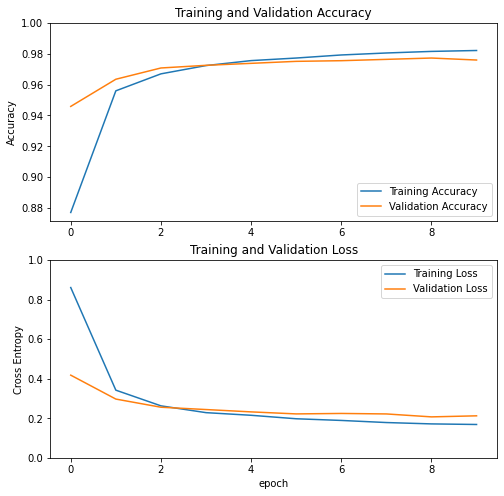

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 2-4. Fine tuning our classification model 

In the previous feature extraction part, we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

**One way to increase performance** even further is to **train (or "fine-tune") the weights of the top layers of the pre-trained model** alongside the training of the classifier you added. The training process will force the **weights to be tuned from generic features maps to features associated specifically to our dataset**.

Also, we should try to fine-tune a **small number of top layers** rather than the whole MobileNet model. In most convolutional networks, **the higher up a layer is, the more specialized it is**. The first few layers learn very simple and generic features which generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. **The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.**

#### Un-freeze the top layers of the model
All we need to do is **unfreeze the base_model** and **set the bottom layers be un-trainable**.(i.e., we will fine-tune a small number of top layers of base mode). Then, you should recompile the model (necessary for these changes to take effect), and resume training.


In [33]:
base_model.trainable = True

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


#### Compile the model
Compile the model using a much lower training rate.

(Our model:  <br>
&emsp;&emsp;base_model, <br>
&emsp;&emsp;global_average_layer,  <br>
&emsp;&emsp;prediction_layer)

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


#### Continue Train the model
If you trained to convergence earlier, this will get you a few percent more accuracy.

In [38]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

# initial_epoch: Integer. Epoch at which to start training (useful for resuming a previous training run).
history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
582/582 [==============================] - 21s 31ms/step - loss: 0.7335 - accuracy: 0.9206 - val_loss: 0.2640 - val_accuracy: 0.9738
Epoch 12/20
582/582 [==============================] - 18s 31ms/step - loss: 0.3794 - accuracy: 0.9562 - val_loss: 0.2622 - val_accuracy: 0.9738
Epoch 13/20
582/582 [==============================] - 18s 31ms/step - loss: 0.3212 - accuracy: 0.9658 - val_loss: 0.2357 - val_accuracy: 0.9755
Epoch 14/20
582/582 [==============================] - 18s 31ms/step - loss: 0.2665 - accuracy: 0.9705 - val_loss: 0.2264 - val_accuracy: 0.9751
Epoch 15/20
582/582 [==============================] - 18s 31ms/step - loss: 0.2381 - accuracy: 0.9749 - val_loss: 0.2468 - val_accuracy: 0.9742
Epoch 16/20
582/582 [==============================] - 18s 31ms/step - loss: 0.1929 - accuracy: 0.9781 - val_loss: 0.2316 - val_accuracy: 0.9772
Epoch 17/20
582/582 [==============================] - 18s 31ms/step - loss: 0.1831 - accuracy: 0.9783 - val_loss: 0.2219 - val_ac

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

(새로운 데이터가 원래 데이터에 비해서 너무 작음)
You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

**After fine tuning the model nearly reaches 98% accuracy.**

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

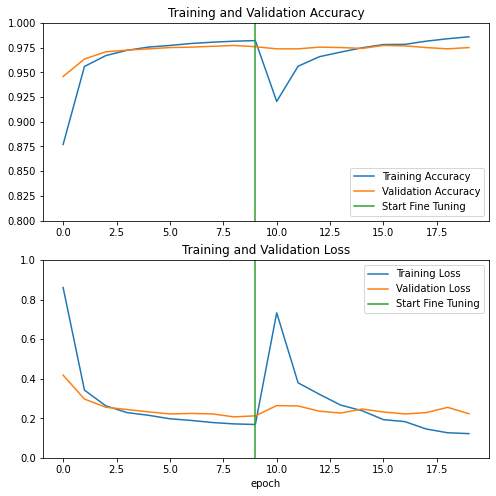

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()